In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import pingouin as pg
import statsmodels.stats.outliers_influence as sms
from functools import reduce
from statsmodels.stats.stattools import durbin_watson
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [3]:
da = pd.read_csv('/home/atrides/Desktop/R/statistics_with_Python/07_Regression/Data_Files/GlastonburyFestivalRegression.dat', sep='\t')
print(da.head())

   ticknumb                   music  day1  day2  day3 change
0      2111                Metaller  2.65  1.35  1.61  -1.04
1      2229                  Crusty  0.97  1.41   .29   -.68
2      2338  No Musical Affiliation  0.84                   
3      2384                  Crusty  3.03                   
4      2401  No Musical Affiliation  0.88   .08             


In [5]:
da.replace(' ' ,np.nan, inplace=True)
da['music'].unique()

array(['Metaller', 'Crusty', 'No Musical Affiliation', 'Indie Kid'],
      dtype=object)

In [6]:
da_ = da[da['change'].notna()]

In [8]:
dummies = pd.get_dummies(da_['music'])
dummy = dummies.iloc[:,0:3]
print(dummy.head())

    Crusty  Indie Kid  Metaller
0        0          0         1
1        1          0         0
9        0          0         0
11       1          0         0
13       0          0         0


In [9]:
da_ = pd.merge(da_, dummy, how='inner', left_index=True, right_index=True)

col =list(da_.columns)
col[-2]='Indie'
da_.columns=col

print(da_.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 800
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ticknumb  123 non-null    int64  
 1   music     123 non-null    object 
 2   day1      123 non-null    float64
 3   day2      123 non-null    object 
 4   day3      123 non-null    object 
 5   change    123 non-null    object 
 6   Crusty    123 non-null    uint8  
 7   Indie     123 non-null    uint8  
 8   Metaller  123 non-null    uint8  
dtypes: float64(1), int64(1), object(4), uint8(3)
memory usage: 12.1+ KB
None


In [13]:
da_['change']=pd.to_numeric(da_['change'])
m03 = ols('change~Crusty+Indie+Metaller', data=da_).fit()
print(m03.summary())

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     3.270
Date:                Tue, 15 Sep 2020   Prob (F-statistic):             0.0237
Time:                        22:14:25   Log-Likelihood:                -126.53
No. Observations:                 123   AIC:                             261.1
Df Residuals:                     119   BIC:                             272.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5543      0.090     -6.134      0.0

#### what does these coeffiecients represent this actually represents the difference in the change in hygiene scores if a person has no musical affiliation,  compared to someone who is a crusty, indie, metal, Rescpectively

### Outliers and Influential cases

In [17]:
summary_ = sms.OLSInfluence(m03).summary_frame()
summary_ = summary_[['cooks_d','standard_resid', 'student_resid', 'hat_diag' ]]
summary_.reset_index(inplace=True, drop=True)
summary_.head()

,cooks_d,standard_resid,student_resid,hat_diag
0,5.571876e-03,-0.761233,-0.759880,0.037037
1,1.956655e-03,0.424279,0.422812,0.041667
2,3.050585e-07,-0.008340,-0.008305,0.017241
3,9.082698e-03,0.914116,0.913480,0.041667
4,1.320307e-03,0.548662,0.547044,0.017241


In [19]:
da_.reset_index(inplace=True, drop=True)

resid = pd.DataFrame(da_['change'] - m03.fittedvalues)
resid.columns = ['residual']
resid.reset_index(inplace=True, drop=True)

In [21]:
dfbeta = pd.DataFrame(pd.DataFrame(sms.OLSInfluence(m03).dfbeta)[0])
dfbeta.columns = ['dfbeta']

In [25]:
cov_ratio = pd.DataFrame(sms.OLSInfluence(m03).cov_ratio)
cov_ratio.columns = ['cov_ratio']

In [22]:
dq = [da_, resid, summary_, dfbeta]

In [23]:
final_summary = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dq)

In [26]:
large_resid  = final_summary[(final_summary['standard_resid']>=2) | (final_summary['standard_resid']<=-2)]
large_resid

,ticknumb,music,day1,day2,day3,change,Crusty,Indie,Metaller,residual,cooks_d,standard_resid,student_resid,hat_diag,dfbeta
7,2604,Crusty,2.57,.11,.02,-2.55,1,0,0,NaN,0.060102,-2.351468,-2.397940,0.041667,4.440892e-16
21,2975,No Musical Affiliation,1.66,2.12,2.7,1.04,0,0,0,NaN,0.023953,2.336931,2.382401,0.017241,2.797036e-02
26,3095,No Musical Affiliation,2.71,.78,.33,-2.38,0,0,0,NaN,0.031410,-2.676086,-2.748813,0.017241,-3.202964e-02
46,3490,No Musical Affiliation,2.55,.82,.29,-2.26,0,0,0,NaN,0.027416,-2.500190,-2.557747,0.017241,-2.992438e-02
69,3792,No Musical Affiliation,1.32,1.7,2.29,0.97,0,0,0,NaN,0.021896,2.234325,2.273109,0.017241,2.674229e-02


In [29]:
k = 3 #number of predictors
n = 123 #number of objervations

average_leverage = (k+1)/n
print(average_leverage)

0.032520325203252036


In [30]:
cvr_limit_high = 1+3*average_leverage
cvr_limit_low  = 1-3*average_leverage

print(cvr_limit_low, cvr_limit_high)

0.9024390243902439 1.0975609756097562


In [31]:
print(cov_ratio.iloc[7])
print(cov_ratio.iloc[21])
print(cov_ratio.iloc[26])
print(cov_ratio.iloc[46])
print(cov_ratio.iloc[69])

cov_ratio    0.892255
Name: 7, dtype: float64
cov_ratio    0.872171
Name: 21, dtype: float64
cov_ratio    0.821091
Name: 26, dtype: float64
cov_ratio    0.848158
Name: 46, dtype: float64
cov_ratio    0.886672
Name: 69, dtype: float64


#### Therefore, we are looking for any cases that deviate substantially from these boundaries.. However, given the Cook’s distance for this case, there is probably little cause for alarm.None of them has a Cook’s distance greater than 1, so none of the cases is having an undue influence on the model.

## Checking Assumptions

#### Checking Assumptions of Independent Errors

In [35]:
print(durbin_watson(m03.resid))

1.8934071205674472


#### Assumption of no multicollinearity

In [37]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
da_ = add_constant(da_)

In [38]:
dz = da_[['const', 'Crusty', 'Indie', 'Metaller']]

In [39]:
dz.reset_index(drop=True, inplace=True)

In [40]:
vif = pd.Series([variance_inflation_factor(dz.values, i) 
               for i in range(1, dz.shape[1])], 
              index=dz.columns[1:])
print(vif)

Crusty      1.137931
Indie       1.100084
Metaller    1.143818
dtype: float64


In [41]:
avg_vif  = np.mean(vif)
print(avg_vif)

1.127277824502383


In [42]:
tolerance  = 1/vif
tolerance 

Crusty      0.878788
Indie       0.909021
Metaller    0.874265
dtype: float64

#### Assumption about the Residuals

In [44]:
prediction = pd.DataFrame(m03.fittedvalues)
prediction.columns = ['predicted']
prediction.reset_index(drop=True, inplace=True)
print(prediction.head())

   predicted
0  -0.525926
1  -0.965833
2  -0.554310
3  -0.965833
4  -0.554310


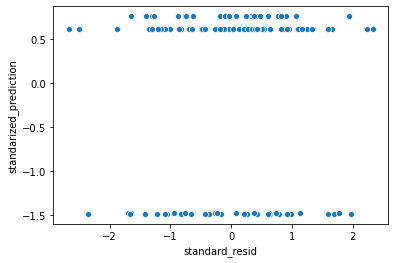

In [45]:
prediction['standarized_prediction']  = (prediction['predicted']-prediction['predicted'].mean())/prediction['predicted'].std()
_ = sns.scatterplot(x= final_summary['standard_resid'], y = prediction['standarized_prediction'] )
plt.show()

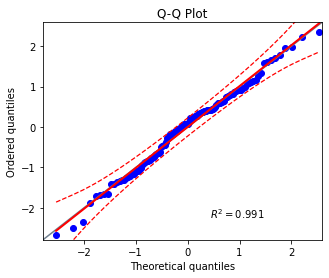

In [46]:
_ = pg.qqplot(final_summary['standard_resid'],)
plt.show()

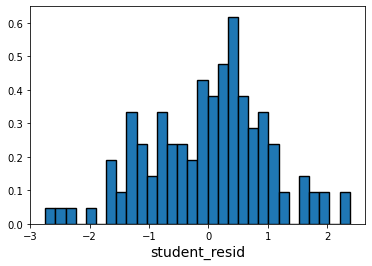

In [47]:
fig,ax = plt.subplots(figsize=(6, 4))
ax = plt.hist(final_summary['student_resid'],density=True,bins=30, edgecolor='black', linewidth=1.4)
plt.xlabel('student_resid', fontsize=14)
plt.show()

### all assumptions are met :)